# TensorFlow, Bands2Vec and TSNE
---------------------------------------------------------


In [1]:
import sqlite3 as sql
import numpy as np

In [4]:
# Connecting to the Kaggle Pitchfork Database 
db = sql.connect('../../data/pitchfork.sqlite')
cursor = db.cursor()

artist_dict = {}
artist_lookup = {}

#An artist class for holding the information
class Artist:
    def __init__(self, name):
        self.name = name
        self.reviews = []
        self.genres = []
        self.scores = []
    def add_review(self, review):
        self.reviews.append(review)
    def add_genre(self, genre):
        self.genres.append(genre)
    def add_score(self, score):
        self.scores.append(score)
    def __str__(self):
        return self.name
 

cursor.execute('select reviews.reviewid, artist, genre, score from reviews join genres on genres.reviewid = reviews.reviewid')
for row in cursor:
    if row[1] not in artist_dict:
        artist_dict[row[1]] = Artist(row[1])
        artist_dict[row[1]].add_review(row[0])
        artist_dict[row[1]].add_genre(row[2])
        artist_dict[row[1]].add_score(row[3])
        artist_lookup[row[1]] = len(artist_lookup)
    else: 
        artist_dict[row[1]].add_review(row[0])
        artist_dict[row[1]].add_genre(row[2])
        artist_dict[row[1]].add_score(row[3])

In [249]:
genres = {}
genre_lookup = {}
scores = {}
cursor.execute('select distinct genre from genres')
for row in cursor:
    genre_lookup[len(genre_lookup)] = row[0] 
    genres[row[0]] = []
    
for i in range(11):
    scores[i] = []
    
for artist in artist_dict: 
    for genre in artist_dict[artist].genres:
        #We don't want to add them more than once - although maybe this could be a weighting
        #as in how 'rocky' are the band?
        if artist not in genres[genre]:
            genres[genre].append(artist_lookup[artist])
    mean_score = np.mean(artist_dict[artist].scores)
    scores[round(mean_score)].append(artist_lookup[artist])

In [250]:
def gen_batch(genres, scores, size, bias):
    xs = np.ndarray(shape=(size), dtype=np.int32)
    ys = np.ndarray(shape=(size, 1), dtype=np.int32)
    for idx in range(size):
        b = np.random.randint(10)
        if b < bias:
            genre = np.random.randint(len(genres))
            g1 = np.random.randint(len(genres[genre_lookup[genre]]))
            g2 = np.random.randint(len(genres[genre_lookup[genre]]))
            while g1 == g2:
                g2 = np.random.randint(len(genres[genre_lookup[genre]]))
            xs[idx] = genres[genre_lookup[genre]][g1]
            ys[idx][0] = genres[genre_lookup[genre]][g2]
        else:
            score = np.random.randint(len(scores))
            s1 = np.random.randint(len(scores[score]))
            s2 = np.random.randint(len(scores[score]))
            while s1 == s2:
                s2 = np.random.randint(len(scores[score]))
            xs[idx] = scores[score][s1]
            ys[idx][0] = scores[score][s2]
    return xs, ys

artist_decode = dict(zip(artist_lookup.values(), artist_lookup.keys()))

In [251]:
xs, ys = gen_batch(genres, scores, 64, 6)

In [252]:
#Before we dive in we need to declare some variables
vocabulary_size = len(artist_lookup)
#How big we want our final vectors to be
embedding_size = 64
#The number of training samples passed per epoch
batch_size = 64
#Number of negative samples to use in NCE [see below]
num_sampled = 16

In [253]:
#BAND2VEC - Tensorflow Time!
import tensorflow as tf
import math 

graph = tf.Graph()

with graph.as_default():
    #Defining variables and functions in a scope is good practice
    with tf.name_scope('inputs'):
        #Tensorflow Placeholders are the mouths of the neural network - they will constantly be fed new information
        training_inputs = tf.placeholder(tf.int32, shape=[batch_size])
        training_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

    #Using the CPU
    with tf.device('/cpu:0'):
        with tf.name_scope('embeddings'):
            #The embeddings - variables are maintained across runs and need to be initialised with a shape and type
            #Each row is a band represented by a vector of length 'embedding_size'
            embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
            #Like passing muliple indices to a numpy array we get the vectors quickly with this function
            embed = tf.nn.embedding_lookup(embeddings, training_inputs)
        
        with tf.name_scope('weights'):
            #Like embeddings we initialise our weights and also...
            nce_weights = tf.Variable(
                tf.truncated_normal(
                    [vocabulary_size, embedding_size],
                    stddev=1.0 / math.sqrt(embedding_size)))
            
        with tf.name_scope('biases'):
            #...our biases
            nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
            
    with tf.name_scope('loss'):
        #Finally our loss function - see below for an explanation of the Noise Contrastive Estimation Approach
        loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights,
                biases=nce_biases,
                labels=training_labels,
                inputs=embed,
                num_sampled=num_sampled,
                num_classes=vocabulary_size))
        
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

In [254]:
#Running our Neural Network!
#First we init the session

iterations = 100000

with tf.Session(graph=graph) as sess:
    #We run the initialize all global variables operation
    sess.run(tf.global_variables_initializer())
    average_loss = 0.0
    #For all of the iterations
    for index in range(iterations):
        #Generate a batch
        ti, tl = gen_batch(genres, scores, batch_size, 8)
        feed_dict = {training_inputs: ti, training_labels: tl}
        #Run the NN! Notice the feed dict feeding our placeholders from before
        _, loss_val = sess.run([optimizer, loss], feed_dict=feed_dict)
        #Some metrics so we can see how we're doing
        average_loss += loss_val
        if (index + 1) % 2000 == 0:
            print('Average loss at step', index + 1, average_loss / (index + 1))
            
    final_embeddings = embeddings.eval()

Average loss at step 2000 33.0436920776
Average loss at step 4000 23.3075806832
Average loss at step 6000 18.0519032232
Average loss at step 8000 14.8340392998
Average loss at step 10000 12.6756510412
Average loss at step 12000 11.1298267201
Average loss at step 14000 9.95716511951
Average loss at step 16000 9.05233187518
Average loss at step 18000 8.33056551315
Average loss at step 20000 7.73677150632
Average loss at step 22000 7.24053499278
Average loss at step 24000 6.82129122252
Average loss at step 26000 6.45967478811
Average loss at step 28000 6.14465060286
Average loss at step 30000 5.86754559934
Average loss at step 32000 5.62180831211
Average loss at step 34000 5.40363687258
Average loss at step 36000 5.20742037915
Average loss at step 38000 5.03080542156
Average loss at step 40000 4.87038479589
Average loss at step 42000 4.72365066662
Average loss at step 44000 4.58807716737
Average loss at step 46000 4.46362710558
Average loss at step 48000 4.35022295124
Average loss at step

In [255]:
try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(perplexity=30, n_components=2, verbose=1, init='pca', n_iter=500, method='exact')
    plot_only = len(artist_lookup)
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])

except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
    print(ex)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 8715
[t-SNE] Computed conditional probabilities for sample 2000 / 8715
[t-SNE] Computed conditional probabilities for sample 3000 / 8715
[t-SNE] Computed conditional probabilities for sample 4000 / 8715
[t-SNE] Computed conditional probabilities for sample 5000 / 8715
[t-SNE] Computed conditional probabilities for sample 6000 / 8715
[t-SNE] Computed conditional probabilities for sample 7000 / 8715
[t-SNE] Computed conditional probabilities for sample 8000 / 8715
[t-SNE] Computed conditional probabilities for sample 8715 / 8715
[t-SNE] Mean sigma: 1.104837
[t-SNE] KL divergence after 250 iterations with early exaggeration: 95.880789
[t-SNE] Error after 500 iterations: 3.462267


In [275]:
#Given a low dimension embedding, find the clostest point to it using Euclidean Distance
from sklearn.metrics.pairwise import euclidean_distances
def find_closest_n(band_embedding, n=1):
    closest = []
    for idx, lde in enumerate(low_dim_embs):
        differences = euclidean_distances([band_embedding], low_dim_embs)
        idxs = np.argsort(differences)
    for i in idxs[0, :n]:
        closest.append(artist_decode[i])
    return closest


def top_n_similar_artists(word, n):
    index = artist_lookup[word]
    vector_representation = low_dim_embs[index]
    esim = euclidean_distances([vector_representation], low_dim_embs)
    eindices = np.argsort(esim)
    top_n = []
    for id1 in eindices[0][:n]:
        top_n.append(artist_decode[id1])
    return top_n

In [265]:
#Kmeans - https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=len(genres))
kmeans.fit(low_dim_embs)
y_kmeans = kmeans.predict(low_dim_embs)

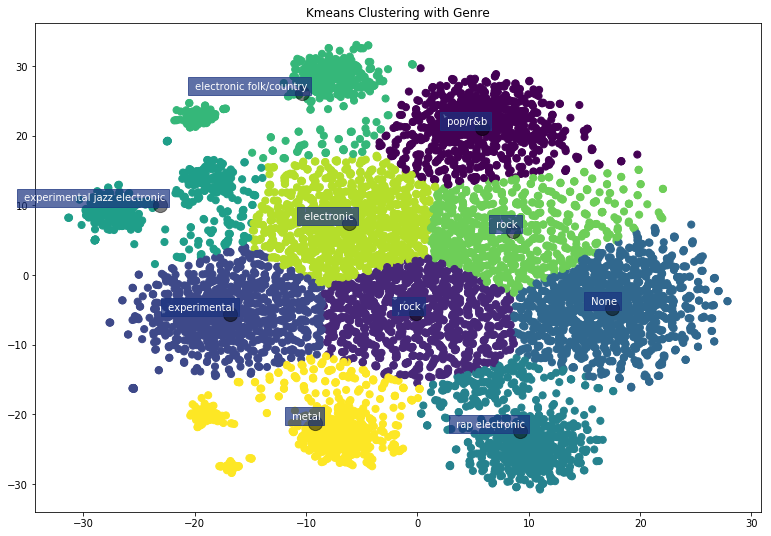

In [281]:
fig, ax = plt.subplots(figsize=(13, 9))
ax.scatter(low_dim_embs[:, 0], low_dim_embs[:, 1], c=y_kmeans, s=50, cmap='viridis')

centres = kmeans.cluster_centers_
centres_labels = []
for centre in centres:
    top_5 = find_closest_n(centre, 5)
    labels = ""
    for artist in top_5:
        g = artist_dict[artist].genres[0]
        if g == None: 
            g = 'None'
        if g not in labels.split(): 
            labels += (' ' + (g))
    centres_labels.append(labels)
    
for idx, label in enumerate(centres_labels):
        x, y = centres[idx, :]
        ax.scatter(x, y, c='black', s=200, alpha=0.5)
        ax.annotate(label,xy=(x, y),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom', color='white', backgroundcolor=(0.1, 0.2, 0.5, 0.7)) 
        
ax.set_title('Kmeans Clustering with Genre')
plt.savefig('./KMEANS_CLUSTERING.png')

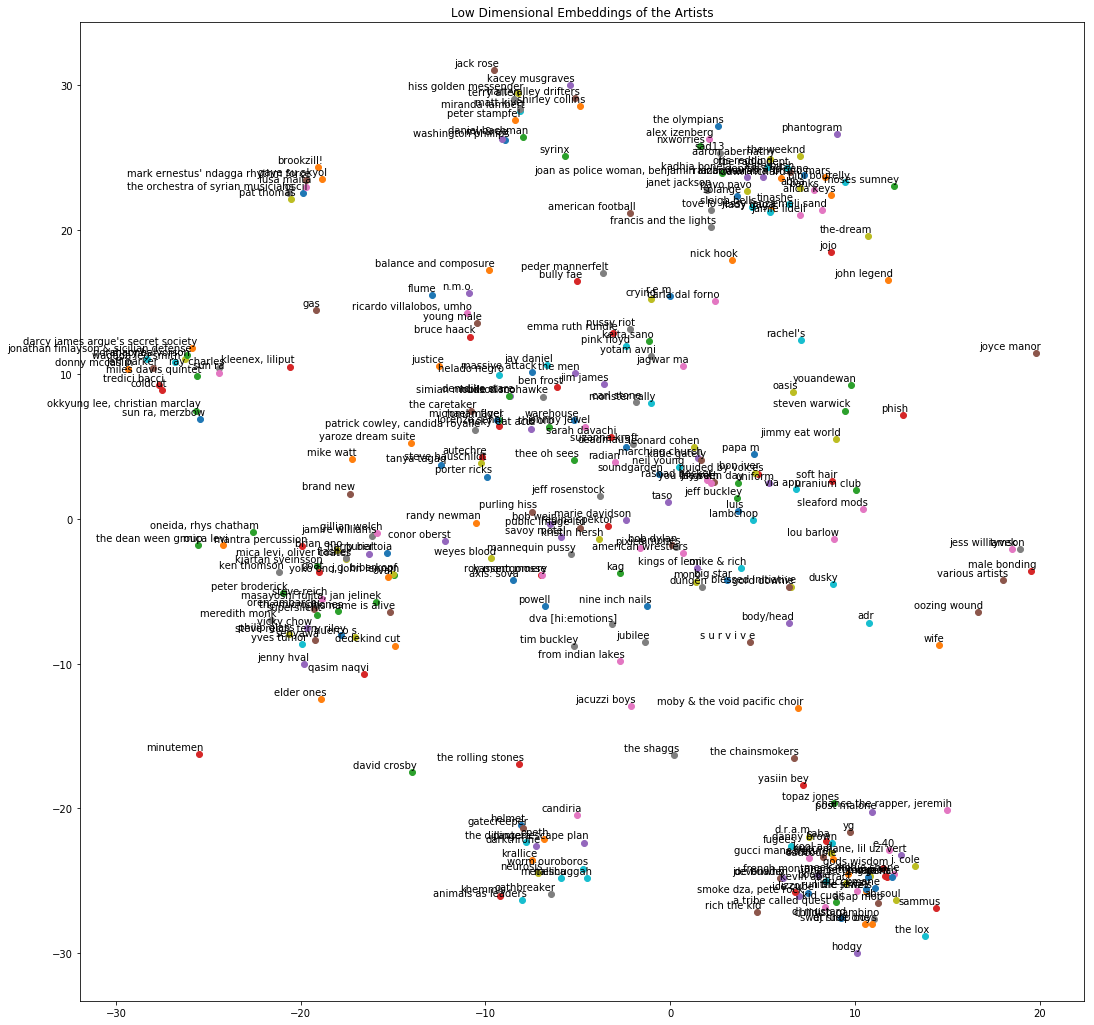

In [302]:
from tempfile import gettempdir
def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',ha='right',va='bottom')
    plt.title('Low Dimensional Embeddings of the Artists')
    #plt.show()
    plt.savefig('./FIRST_300.png')

labels = []
for i in range(300):
    if artist_decode[i] != 'joey bada$$':
        labels.append(artist_decode[i])
plot_with_labels(low_dim_embs, labels, './other.png')

In [301]:
print(artist_dict['coil'].genres, np.mean(artist_dict['coil'].scores))
print(artist_dict['elder ones'].genres, np.mean(artist_dict['elder ones'].scores))
electronic_experimental = low_dim_embs[artist_lookup['coil']] - low_dim_embs[artist_lookup['elder ones']]

['electronic', 'experimental', 'rock'] 7.9
['experimental'] 7.8


In [300]:
bands = find_closest_n(electronic_experimental, 3)
for band in bands:
    print(band, 'Mean Score:' , np.mean(artist_dict[band].scores), 'Genres:', artist_dict[band].genres)

black lips Mean Score: 7.48 Genres: ['rock', 'rock', 'rock', 'rock', 'rock']
crookers Mean Score: 5.5 Genres: ['electronic']
guided by voices Mean Score: 7.23043478261 Genres: ['rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock', 'rock']
